In [1]:
import glob

run_number = 4495#"MC/Kr"
map_run_number = 4446
outputfolder = '/home/jmbenlloch/reset_data/4495/dsts'
inputfiles = glob.glob("/home/jmbenlloch/reset_data/4495/pmaps/pmaps*.root.h5")

In [2]:
inputfiles

['/home/jmbenlloch/reset_data/4495/pmaps/pmaps.gdcsnext.245_4495.root.h5',
 '/home/jmbenlloch/reset_data/4495/pmaps/pmaps.gdcsnext.096_4495.root.h5',
 '/home/jmbenlloch/reset_data/4495/pmaps/pmaps.gdcsnext.498_4495.root.h5',
 '/home/jmbenlloch/reset_data/4495/pmaps/pmaps.gdcsnext.317_4495.root.h5',
 '/home/jmbenlloch/reset_data/4495/pmaps/pmaps.gdcsnext.203_4495.root.h5',
 '/home/jmbenlloch/reset_data/4495/pmaps/pmaps.gdcsnext.700_4495.root.h5',
 '/home/jmbenlloch/reset_data/4495/pmaps/pmaps.gdcsnext.873_4495.root.h5',
 '/home/jmbenlloch/reset_data/4495/pmaps/pmaps.gdcsnext.760_4495.root.h5',
 '/home/jmbenlloch/reset_data/4495/pmaps/pmaps.gdcsnext.112_4495.root.h5',
 '/home/jmbenlloch/reset_data/4495/pmaps/pmaps.gdcsnext.653_4495.root.h5',
 '/home/jmbenlloch/reset_data/4495/pmaps/pmaps.gdcsnext.841_4495.root.h5',
 '/home/jmbenlloch/reset_data/4495/pmaps/pmaps.gdcsnext.860_4495.root.h5',
 '/home/jmbenlloch/reset_data/4495/pmaps/pmaps.gdcsnext.763_4495.root.h5',
 '/home/jmbenlloch/reset_

# IC functions

In [3]:
import os
import functools
import itertools
import time
print("Running on ", time.asctime())

import numpy             as np
import tables            as tb
import matplotlib.pyplot as plt

import invisible_cities.database.load_db as dbf
import invisible_cities.filters.s1s2_filter as s1s2filt
import invisible_cities.reco.pmaps_functions  as pmapsf
import invisible_cities.reco.pmaps_functions_c  as pmapsfc
import invisible_cities.reco.corrections    as corrf
import invisible_cities.core.core_functions as coref
import invisible_cities.core.core_functions_c as corefc
import invisible_cities.core.fit_functions  as fitf
import invisible_cities.reco.dst_functions as dstf
import invisible_cities.reco.reset_functions as rstf
#import invisible_cities.reco.reset_functions_old as rstfOld
import invisible_cities.io.table_io as tbiof
import invisible_cities.io.pmap_io as pmapio
import invisible_cities.io.dst_io as dstio
import invisible_cities.reco.xy_algorithms as xyf

from invisible_cities.icaro.hst_functions import hist
from invisible_cities.icaro.hst_functions import hist2d
from invisible_cities.icaro.hst_functions import hist2d_profile
from invisible_cities.icaro.hst_functions import labels
from invisible_cities.icaro.hst_functions import gausstext

from invisible_cities.reco.tbl_functions     import get_event_numbers_and_timestamps_from_file_name
from invisible_cities.core.system_of_units import pes, mm, mus, ns

from invisible_cities.evm.pmaps import S2, S2Si, Peak

Running on  Tue Dec  5 12:48:02 2017


### General plotting options

In [4]:
%matplotlib inline

np.warnings.filterwarnings('ignore')

plt.rcParams["figure.figsize"]          = 8, 6
plt.rcParams["font.size"]               = 15
plt.rcParams["figure.max_open_warning"] = 100

profOpt = "--k"
fitOpt  = "r"

### SiPM info

In [5]:
DataSiPM = dbf.DataSiPM(run_number)
DataPMT = dbf.DataPMT(run_number)

### Plots

In [6]:
def plot_map(xy_map, run=""):
    x , y  = xy_map._xs
    x0, y0 = np.min(x) - np.diff(x)[0]/2, np.min(y) - np.diff(y)[0]/2
    x1, y1 = np.max(x) + np.diff(x)[0]/2, np.max(y) + np.diff(y)[0]/2
    f      = xy_map._fs
    u      = xy_map._us
    x, y   = np.repeat(x, y.size), np.tile(y, x.size)

    plt.figure(figsize=(20,8))

    plt.subplot(1, 2, 1)
    hist2d(x, y, f.shape, ((x0, x1), (y0, y1)), weights=f.flatten(), new_figure=False)
    plt.colorbar().set_label("Correction factor")
    labels("x (mm)", "y (mm)", str(run))

    plt.subplot(1, 2, 2)
    hist2d(x, y, u.shape, ((x0, x1), (y0, y1)), weights=u.flatten(), new_figure=False)
    plt.colorbar().set_label("Correction uncertainty")
    labels("x (mm)", "y (mm)", str(run))

#### Function to calculate lifetime

In [7]:
def lifetime_calculation(z, zrange, energy, erange):
    hist(energy, 50, erange)
    labels("S2 energy (pes)", "Entries", "Fidualized energy spectrum")

    low_cut   = 11000 * np.exp(-0.0009*z)
    high_cut  = 14000 * np.exp(-0.0009*z)
    sel       = coref.in_range(energy, low_cut, high_cut) # remove low and high E background

    hist2d(z, energy, (100, 50), range=(zrange, erange))
    x, y, u_y = fitf.profileX(z[sel], energy[sel], 100, xrange=zrange, yrange=erange)

    plt.plot(x, y, profOpt)
    plt.plot(z,  low_cut, "k.")
    plt.plot(z, high_cut, "k.")

    Zrange_LT = 50, 350
    
    seed = np.max(y), (x[15] - x[5])/np.log(y[15]/y[5])
    f    = fitf.fit(fitf.expo, x, y, seed, fit_range=Zrange_LT, sigma=u_y)

    plt.plot(x, f.fn(x), fitOpt)
    print("Energy at z=0 = {:.1f} +- {:.1f}".format( f.values[0], f.errors[0]))
    print("Lifetime      = {:.1f} +- {:.1f}".format(-f.values[1], f.errors[1]))
    print("Chi2          = {:.2f}          ".format(f.chi2))

    labels("Drift time ($\mu$s)", "S2 energy (pes)", "Fiducialized energy spectrum vs Z")

    return corrf.LifetimeCorrection(-f.values[1], f.errors[1])

In [8]:
class ResetDST(tb.IsDescription):
    X        = tb.Float64Col(pos=0)
    Y        = tb.Float64Col(pos=1)
    Z        = tb.Float64Col(pos=2)
    E        = tb.Float64Col(pos=3)
    EventID  = tb.UInt32Col(pos=4)
    PeakNo = tb.UInt32Col(pos=5)
    Iteration = tb.UInt32Col(pos=6)

In [9]:
def rebin_s2si(s2, s2si, rf):
    """given an s2 and a corresponding s2si, rebin them by a factor rf"""
    assert rf >= 1 and rf % 1 == 0
    t, e, sipms = pmapsf.rebin_s2si_peak(s2[0], s2[1], s2si, rf)
    s2d_rebin = [t, e]
    s2sid_rebin = sipms

    return s2d_rebin, s2sid_rebin

In [10]:
def rebin_s2pmt(s2pmt, stride):
    """rebin: s2 times (taking mean), s2 energies, and s2 sipm qs, by stride"""
    # cython rebin_array is returning memoryview so we need to cast as np array
    return   [corefc.rebin_array(s2pmt.t , stride, remainder=True, mean=True), \
              corefc.rebin_array(s2pmt.E , stride, remainder=True)]

##  Read data

### PMap parameter selection

In [11]:
init_val = {}

init_val['s1_emin'] = 54 * pes
init_val['s1_emax'] = 2400. * pes
init_val['s1_wmin'] = 7*25 * ns
init_val['s1_wmax'] = 16*25 * ns
init_val['s1_hmin'] = 12. * pes
init_val['s1_hmax'] = 400. * pes
init_val['s1_num'] = 1
init_val['s1_ethr'] = 0.5 * pes

init_val['s2_emin'] = 200000. * pes
init_val['s2_emax'] = 2.e6 * pes
init_val['s2_wmin'] = 4.* mus
init_val['s2_wmax'] = 500. * mus
init_val['s2_hmin'] = 600. * pes
init_val['s2_hmax'] = 60000. * pes
init_val['s2_numMin'] = 1
init_val['s2_numMax'] = 3
init_val['s2_ethr'] = 0. * pes
init_val['s2_nsipmmin'] = 1
init_val['s2_nsipmmax'] = 1792

def refresh_selector(param_val):
    selector = s1s2filt.S12Selector(s1_nmin = param_val['s1_num'], s1_nmax = param_val['s1_num'], s1_emin = param_val['s1_emin'], s1_emax = param_val['s1_emax'], s1_ethr = param_val['s1_ethr'],
                                    s1_wmin = param_val['s1_wmin'], s1_wmax = param_val['s1_wmax'], s1_hmin = param_val['s1_hmin'], s1_hmax = param_val['s1_hmax'],
                                    s2_nmin = param_val['s2_numMin'], s2_nmax = param_val['s2_numMax'], s2_emin = param_val['s2_emin'], s2_emax = param_val['s2_emax'], 
                                    s2_wmin = param_val['s2_wmin'], s2_wmax = param_val['s2_wmax'], s2_hmin = param_val['s2_hmin'], s2_hmax = param_val['s2_hmax'], 
                                    s2_nsipmmin = param_val['s2_nsipmmin'], s2_nsipmmax = param_val['s2_nsipmmax'], s2_ethr = param_val['s2_ethr'])

    return selector

### Compute lifetime correction

In [12]:
ZCorr = corrf.LifetimeCorrection(1093.77, 23.99)

### Load correction maps

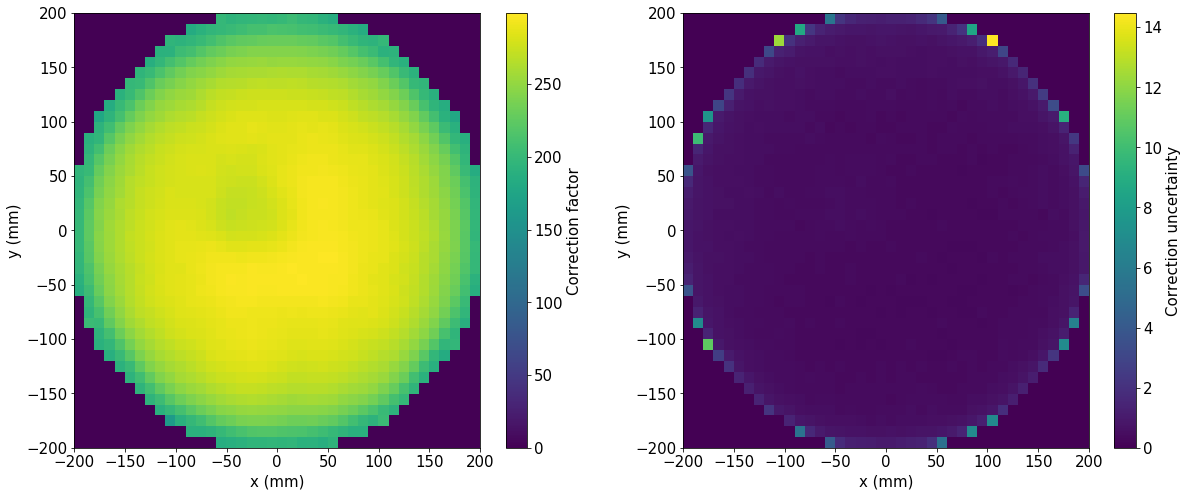

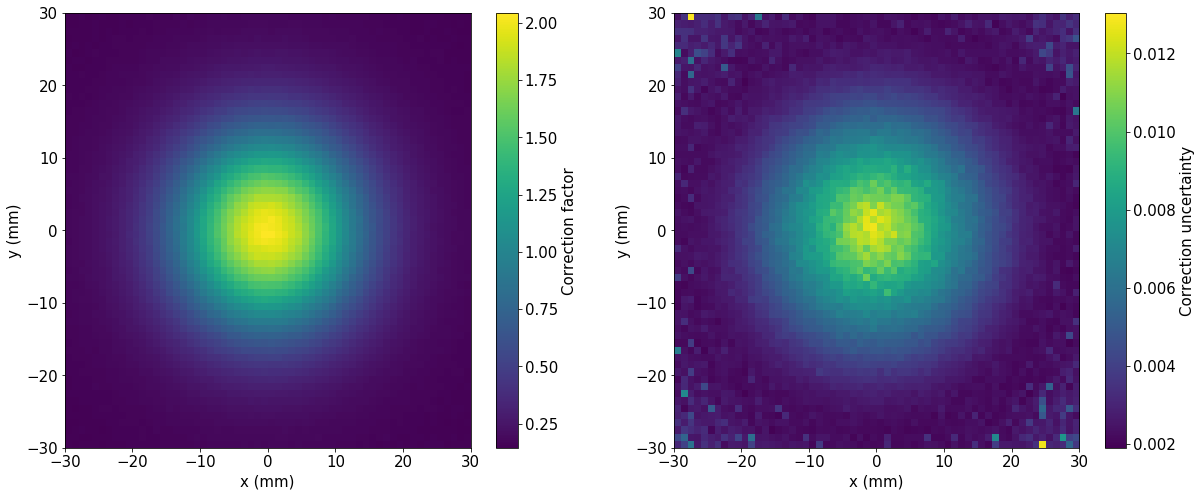

In [13]:
pmt_xy_map = []
sipm_xy_map = []
modePMT = "Sum"
#modePMT = "Individual"
nPMT = 11
pmt_sens = np.arange(0,nPMT,1)

pmtcorr = "/Users/ansimez/Documents/InvCit/hdf5/{}/PMT_Map_corr_keV".format(map_run_number)
sipmcorr = "/Users/ansimez/Documents/InvCit/hdf5/{}/SiPM_Map_corr_z".format(map_run_number)

pmtcorr = "/home/jmbenlloch/reset_data/mapas/PMT_Map_corr_keV.h5"
pmtcorr_i = "/home/jmbenlloch/reset_data/mapas/PMT_Map_corr_keV_{}_4734.h5"
sipmcorr = "/home/jmbenlloch/reset_data/mapas/SiPM_Map_corr_z{}.0_keV.h5"

zstep = 100
z_scan = np.arange(0,600,zstep)

for zmap in z_scan:
    sipmcorr_file = sipmcorr.format(zmap)
    sipm_xy_map.append(dstf.load_xy_corrections(sipmcorr_file, group="ResetMap", node="SiPM"))

if modePMT == "Sum":
    pmt_xy_map.append(dstf.load_xy_corrections(pmtcorr, group="ResetMap", node="PMT"))
elif modePMT == "Individual":
    for nsens in pmt_sens:
        pmtcorr_file = pmtcorr_i.format(nsens)
        pmt_xy_map.append(dstf.load_xy_corrections(pmtcorr_file, group="ResetMap", node="PMT"))
#        pmt_xy_map.append(dstf.load_xy_corrections(pmtcorr_file+".h5"))
else:
    print("Invalid mode")
    
    
plot_map(pmt_xy_map[0])
plot_map(sipm_xy_map[3])

## Load event

In [14]:
slice_width = 2.

sipm_dist = 20.
point_dist = 20.
sizeX = 2.
sizeY = 2.
sipm_thr = 5.
iterations = 100
fCathode = True
fAnode = True
e_thres = 0.
verbose = False
verboseMLEM = True
rMax = 198
#zstep = 100
#modePMT = "Individual"
#nPMT = 11

#outputfolder = "/Users/ansimez/Documents/InvCit/hdf5/{}/reset_dst/".format(run_number)
outputfolder = '/home/jmbenlloch/reset_data/4495/reset_dst'
if not os.path.exists(outputfolder):
    os.mkdir(outputfolder)
    
in_limit = 189
filestep = 1
s2pmt_file = {}

#for fnumber, file in enumerate(inputfiles[in_limit:in_limit+filestep]):
for fnumber, file in enumerate(['/home/jmbenlloch/reset_data/4495/pmaps/pmaps.gdcsnext.189_4495.root.h5']):
    outputfile = outputfolder + "reset_dst_"+modePMT+"_{}_select.h5".format(fnumber+in_limit)
    h5out = tb.open_file(outputfile, 'w')
    dst_table = tbiof.make_table(h5out, 
                            group = "Reset_DST",
                            name = "Reset voxels",
                            fformat = ResetDST,
                            description = 'Reset voxels',
                            compression = "ZLIB4")
    row = dst_table.row 
    print("Running on ", time.asctime())
    try: 
#        s1_file, s2_file, s2si_file, _, s2pmt_file = pmapio.load_pmaps_with_ipmt(file)
        s1_file, s2_file, s2si_file, = pmapio.load_pmaps(file)
    except: 
        print("File {} could not be opened".format(file))
    else:
        common_events = set(s1_file.keys()) & set(s2_file.keys()) & set(s2si_file.keys())
        s1_all = dict({k:v for k,v in s1_file.items() if k in common_events})
        s2_all = dict({k:v for k,v in s2_file.items() if k in common_events})
        s2si_all =  dict({k:v for k,v in s2si_file.items() if k in common_events})
        s2pmt_all = dict({k:v for k,v in s2pmt_file.items() if k in common_events})
        
        select = refresh_selector(init_val)

#        for evt in range(1,2):
        for evt in s1_all:
            if(evt != 21215):
                continue
            else:
                print("file: {}".format(fnumber))
            if(verbose):
                print("Filter")
                %timeit(s1s2filt.s1s2_filter(select, s1_all[evt], s2_all[evt], s2si_all[evt]))

            if not s1s2filt.s1s2_filter(select, s1_all[evt], s2_all[evt], s2si_all[evt]):
                continue
            s1_cut = select.select_valid_peaks(s1_all[evt], select.s1_ethr, select.s1e, select.s1w, select.s1h)
            s2_cut = select.select_valid_peaks(s2_all[evt], select.s2_ethr, select.s2e, select.s2w, select.s2h)
            s2si_cut = select.select_s2si(s2si_all[evt], select.nsi)
    
            print("evt: ", evt)
            #print("Filter passed")
            #print(fnumber, file)
            if(verbose):
                print("select_valid_peaks")
                %timeit(select.select_valid_peaks(s1_all[evt], select.s1_ethr, select.s1e, select.s1w, select.s1h))
                %timeit(select.select_valid_peaks(s2_all[evt], select.s2_ethr, select.s2e, select.s2w, select.s2h))
                %timeit(select.select_s2si(s2si_all[evt], select.nsi))
            
            s1 = s1_all[evt].peak_waveform(0)
            t0 = s1.t[np.argmax(s1.E)]

            s2_cut = [peakno for peakno, v in s2_cut.items() if v == True]
            s2si_cut = [peakno for peakno, v in s2si_cut.items() if v == True]
            
            valid_peaks = set(s2_cut) & set(s2si_cut)

            for no in valid_peaks:
                s2 = s2si_all[evt].s2d[no]
                s2si = s2si_all[evt].s2sid[no]
                if modePMT == "Individual":
                    s2pmt = []
                    for nsens in pmt_sens:
                        s2pmt.append(rebin_s2pmt(s2pmt_all[evt].pmt_waveform(no, nsens), slice_width))
                s2, s2si = rebin_s2si(s2, s2si, slice_width)
                if(verbose):
                    print("Rebin")
                    %timeit(rebin_s2si(s2, s2si, slice_width))
                    
                for tbin, e in enumerate(s2[1]):
                    slice_ = pmapsfc.sipm_ids_and_charges_in_slice(s2si, tbin)
                    if len(slice_[0]) <= 0:
                        continue
                    if(verbose):
                        print("Charges in slice")
                        %timeit(pmapsfc.sipm_ids_and_charges_in_slice(s2si, tbin))
                    z = (np.average(s2[0][tbin], weights=s2[1][tbin]) - t0)/1000.
                    if(z>550):
                        continue
                    if(verbose):
                        print("Z calc")
                        %timeit((np.average(s2[0][tbin], weights=s2[1][tbin]) - t0)/1000.)
                    #Create voxels
                    sens_q = np.array(slice_[1]*ZCorr(z).value)
                    if len(sens_q[sens_q>sipm_thr]) <= 0:
                        continue     
                    
                    break
                    vox = rstf.CreateVoxels(DataSiPM, np.array(slice_[0]), sens_q, point_dist, sipm_thr, sizeX, sizeY, rMax)
                    #print ("vox: ", vox)
#                    voxOld = rstfOld.CreateVoxels(DataSiPM, np.array(slice_[0]), sens_q, point_dist, sipm_thr, sizeX, sizeY, rMax)
                    if len(vox[0]) <= 0:
                        continue
                    if(verbose):
                        print("Create vox")
                        %timeit(rstf.CreateVoxels(DataSiPM, np.array(slice_[0]), sens_q, point_dist, sipm_thr, sizeX, sizeY))
                    #Create anode and cathode response 
                    anode_response = rstf.CreateSiPMresponse(DataSiPM, np.array(slice_[0]), sens_q, sipm_dist, sipm_thr, vox)
#                    anode_responseOld = rstfOld.CreateSiPMresponse(DataSiPM, np.array(slice_[0]), sens_q, sipm_dist, sipm_thr, voxOld)

                    if modePMT == "Sum":
                        cath_response = np.array([e*ZCorr(z).value])
                    elif modePMT == "Individual":
                        cath_response = []
                        for nsens in pmt_sens:
                            cath_response.append(s2pmt[nsens][1][tbin]*ZCorr(z).value)
                    else:
                        print("Invalid mode")
                    
                    if(verbose):
                        print("Anode and cath response")
                        %timeit(rstf.CreateSiPMresponse(DataSiPM, np.array(slice_[0]), sens_q, sipm_dist, sipm_thr, vox))
                        %timeit(np.array([e*ZCorr(z).value]))
                    
                    #Run MLEM
                    imageIter = vox
#                    imageIterOld = voxOld
#                    imageIter2 = vox
                    voxDX, voxDY = rstf.computeDiff(DataSiPM, vox, anode_response)
#                    voxDXOld, voxDYOld = rstfOld.computeDiff(DataSiPM, voxOld, anode_responseOld)
#                    selVoxOld, selSensOld = rstfOld.createSel(voxDXOld, voxDYOld, anode_responseOld, sipm_dist)
                    selVox, selSens = rstf.createSel(voxDX, voxDY, anode_response, sipm_dist)
                    if(verbose):
                        print("voxD and sel and prob")
                        %timeit(rstf.computeDiff(DataSiPM, vox, anode_response))
                        %timeit(rstf.createSel(voxDX, voxDY, anode_response, sipm_dist))
                        %timeit(rstf.computeProb(pmt_xy_map, sipm_xy_map, voxDX, voxDY, vox[0], vox[1]))
#                    print("Slice ini at ", time.asctime())
                    z_index = int(z//zstep )
#                    print(z)
#                    print(z_index)
                    sipm_prob, pmt_prob = rstf.computeProb(pmt_xy_map, sipm_xy_map[z_index], voxDX, voxDY, vox[0], vox[1])
#                    sipm_probOld, pmt_probOld = rstfOld.computeProb(pmt_xy_map, sipm_xy_map[z_index], voxDXOld, voxDYOld, voxOld[0], voxOld[1])

                    j = 0
                    for j in range(iterations):
                        if(verboseMLEM):
                            print("MLEM_step")
                            %timeit rstf.MLEM_step(voxDX, voxDY, imageIter, selVox, selSens, anode_response, cath_response, pmt_prob, sipm_prob, sipm_dist=sipm_dist, eThres=e_thres, fCathode = fCathode, fAnode = fAnode)
                            print("AnodeForward")
                            %timeit(rstf.ComputeAnodeForward(voxDX, voxDY, imageIter, anode_response, sipm_dist, sipm_prob, selVox))
                            print("CathodeForward")
                            %timeit(rstf.ComputeCathForward(vox, cath_response, pmt_prob))
#                        imageIter = rstf.MLEM_step(voxDX, voxDY, imageIter, anode_response, cath_response, pmt_xy_map, sipm_xy_map, sipm_dist=sipm_dist, eThres=e_thres, fCathode = fCathode, fAnode = fAnode)    
#                        anode_forward = rstf.ComputeAnodeForward(voxDX, voxDY, imageIter, anode_response, sipm_dist, sipm_prob, selVox)
#                        cath_forward = rstf.ComputeCathForward(vox, cath_response, pmt_prob)
#                        anode_forwardOld = rstfOld.ComputeAnodeForward2(voxDXOld, voxDYOld, imageIterOld, anode_responseOld, sipm_dist, sipm_probOld, selVoxOld)
#                        cath_forwardOld = rstfOld.ComputeCathForward2(voxOld, cath_response, pmt_probOld)
                        imageIter = rstf.MLEM_step(voxDX, voxDY, imageIter, selVox, selSens, anode_response, cath_response, pmt_prob, sipm_prob, sipm_dist=sipm_dist, eThres=e_thres, fCathode = fCathode, fAnode = fAnode)  
#                        imageIterOld = rstfOld.MLEM_step2(voxDXOld, voxDYOld, imageIterOld, selVoxOld, selSensOld, anode_responseOld, cath_response, pmt_probOld, sipm_probOld, sipm_dist=sipm_dist, eThres=e_thres, fCathode = fCathode, fAnode = fAnode)  
                        
#                        for iv in range(len(imageIter[0])):
#                            if imageIter[2][iv] <= 0.00001:
#                                continue
#                            row['X'] = imageIter[0][iv]
#                            row['Y'] = imageIter[1][iv]
#                            row['Z'] = z
#                            row['E'] = imageIter[2][iv]
#                            row['PeakNo'] = no
#                            row['EventID'] = evt
#                            row['Iteration'] = j+1
#                            row.append() 
                        
    #Save Event
                    for iv in range(len(imageIter[0])):
                        if imageIter[2][iv] <= 0.1:
                            continue
                        row['X'] = imageIter[0][iv]
                        row['Y'] = imageIter[1][iv]
                        row['Z'] = z
                        row['E'] = imageIter[2][iv]
                        row['PeakNo'] = no
                        row['EventID'] = evt
                        row['Iteration'] = j+1
                        row.append() 
    h5out.close()                    


Running on  Tue Dec  5 12:48:11 2017
file: 0
evt:  21215


In [15]:
vox = rstf.CreateVoxels(DataSiPM, np.array(slice_[0]), sens_q, point_dist, sipm_thr, sizeX, sizeY, rMax)

In [16]:
anode_response = rstf.CreateSiPMresponse(DataSiPM, np.array(slice_[0]), sens_q, sipm_dist, sipm_thr, vox)

In [17]:
voxDX, voxDY = rstf.computeDiff(DataSiPM, vox, anode_response)

In [18]:
selVox, selSens = rstf.createSel(voxDX, voxDY, anode_response, sipm_dist)

In [19]:
z_index = int(z//zstep )
sipm_prob, pmt_prob = rstf.computeProb(pmt_xy_map, sipm_xy_map[z_index], voxDX, voxDY, vox[0], vox[1])

In [20]:
cath_response = np.array([e*ZCorr(z).value])

In [21]:
imageIter = vox
imageIter = rstf.MLEM_step(voxDX, voxDY, imageIter, selVox, selSens, anode_response, cath_response, pmt_prob, sipm_prob, sipm_dist=sipm_dist, eThres=e_thres, fCathode = fCathode, fAnode = fAnode)  

In [22]:
%timeit(rstf.MLEM_step(voxDX, voxDY, imageIter, selVox, selSens, anode_response, cath_response, pmt_prob, sipm_prob, sipm_dist=sipm_dist, eThres=e_thres, fCathode = fCathode, fAnode = fAnode))

144 ms ± 2.95 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


# CUDA

## Voxels

In [59]:
def CreateVoxels(DataSiPM, sens_id, sens_q, point_dist, sipm_thr, sizeX, sizeY, rMax):
    voxX = []
    voxY = []
    voxE = []
    dist = point_dist
    selC = (sens_q > sipm_thr)
    rangex = np.arange(DataSiPM.X[sens_id[selC]].values.min()-dist, DataSiPM.X[sens_id[selC]].values.max()+dist, sizeX)
    rangey = np.arange(DataSiPM.Y[sens_id[selC]].values.min()-dist, DataSiPM.Y[sens_id[selC]].values.max()+dist, sizeY)
    for x in rangex:
        for y in rangey:
            if(np.sqrt(x*x+y*y) > rMax):
                continue
            voxX.append(x)
            voxY.append(y)
            voxE.append(sens_q.mean()) # Why mean?
    #TODO try to avoid using lists before creating the numpy array        
    data = np.empty(len(voxX), dtype={'names':('x', 'y', 'E'),
                          'formats':('f4', 'f4', 'f4')})
    data['x'] = voxX
    data['y'] = voxY
    data['E'] = voxE
    return data


In [60]:
voxels = CreateVoxels(DataSiPM, np.array(slice_[0]), sens_q, point_dist, sipm_thr, sizeX, sizeY, rMax)
print(voxels.shape)
print(voxels.dtype)

(1430,)
[('x', '<f4'), ('y', '<f4'), ('E', '<f4')]


# Example

In [25]:
import pycuda.driver as cuda
import pycuda.autoinit
import numpy
from pycuda.compiler import SourceModule

# Copy data to device
voxels_d = cuda.to_device(voxels)

print("original arrays")
print(voxels)

mod = SourceModule("""
    #include <stdio.h>
    
    struct Voxels {
        float x;
        float y;
        float E;
    };

    __global__ void double_array(Voxels *v)
    {
        v = v + threadIdx.x;
        v->x *= 2;
        v->y *= 2;
        v->E *= 2;
        printf("x: %f, y: %f, E: %f\\n", v->x, v->y, v->E);
    }
    """)
func = mod.get_function("double_array")
func(voxels_d, block=(500, 1, 1), grid=(1, 1))

print("doubled arrays")
voxels = cuda.from_device(voxels_d, voxels.shape, voxels.dtype)
print(voxels)

original arrays
[( 115.,  25.,  6.39644432) ( 115.,  27.,  6.39644432)
 ( 115.,  29.,  6.39644432) ..., ( 193.,  39.,  6.39644432)
 ( 193.,  41.,  6.39644432) ( 193.,  43.,  6.39644432)]
doubled arrays
[( 230.,  50.,  12.79288864) ( 230.,  54.,  12.79288864)
 ( 230.,  58.,  12.79288864) ..., ( 193.,  39.,   6.39644432)
 ( 193.,  41.,   6.39644432) ( 193.,  43.,   6.39644432)]


## SiPM response

In [26]:
def CreateSiPMresponse(DataSiPM, sens_id, sens_q, sipm_dist, sipm_thr, vox):
    ids     = []
    charges = []
    selDB = (DataSiPM.X.values >= vox[0].min()-sipm_dist) & (DataSiPM.X.values <= vox[0].max()+sipm_dist)
    selDB = selDB & (DataSiPM.Y.values >= vox[1].min()-sipm_dist) & (DataSiPM.Y.values <= vox[1].max()+sipm_dist)
    for ID in DataSiPM[selDB].index.values:
        sel = (sens_id==ID)
        ids.append(ID)
        if sens_q[sel] > sipm_thr:
            charges.append(sens_q[sel])
        else:
            charges.append(0)
            
    data = np.empty(len(ids), dtype={'names':('id', 'charge'),
                          'formats':('i4', 'f4')})
    data['id']     = ids
    data['charge'] = charges
    return data


In [27]:
anode_response = CreateSiPMresponse(DataSiPM, np.array(slice_[0]), sens_q, sipm_dist, sipm_thr, vox)
print (anode_response.shape)
print (anode_response.dtype)

(144,)
[('id', '<i4'), ('charge', '<f4')]


In [28]:
anode_response

array([(1352,   0.        ), (1353,   0.        ), (1354,   0.        ),
       (1355,   0.        ), (1356,   0.        ), (1357,   0.        ),
       (1358,   0.        ), (1359,   0.        ), (1360,   0.        ),
       (1361,   0.        ), (1362,   0.        ), (1363,   0.        ),
       (1364,   0.        ), (1365,   0.        ), (1366,   0.        ),
       (1367,   0.        ), (1368,   0.        ), (1369,   0.        ),
       (1370,   0.        ), (1371,   0.        ), (1372,   0.        ),
       (1373,   0.        ), (1374,   0.        ), (1375,   0.        ),
       (1376,   0.        ), (1377,   0.        ), (1378,   0.        ),
       (1379,   0.        ), (1380,   0.        ), (1381,   0.        ),
       (1382,   0.        ), (1383,   0.        ), (1384,  14.72511387),
       (1385,  18.30488396), (1386,   6.26837349), (1387,   0.        ),
       (1388,   0.        ), (1389,   0.        ), (1390,   0.        ),
       (1391,   0.        ), (1392,  14.59842777), 

## Compute probabilities

In [29]:
def computeProb(pmt_xy_map, sipm_xy_map, voxDX, voxDY, voxX, voxY):
    xyprob = [sipm_xy_map(voxDX[j], voxDY[j]).value for j in range(len(voxDX))]
    pmtprob = []
    for j in range(len(voxDX)):
        pmtprob.append([pmt_xy_map[i](voxX[j], voxY[j]).value[0] for i in range(len(pmt_xy_map))])
    return np.array(xyprob, dtype='f4'), np.array(pmtprob, dtype='f4')


In [30]:
z_index = int(z//zstep )
sipm_prob, pmt_prob = computeProb(pmt_xy_map, sipm_xy_map[z_index], voxDX, voxDY, vox[0], vox[1])

In [31]:
print(pmt_prob.shape)
print(pmt_prob.dtype)

(1430, 1)
float32


In [32]:
print(sipm_prob.shape)
print(sipm_prob.dtype)

(1430, 144)
float32


## Compute diff

In [33]:
def computeDiff(DataSiPM, oldVox, anode_response):
    sensx = DataSiPM.X[anode_response['id']].values
    sensy =  DataSiPM.Y[anode_response['id']].values
    voxD = np.array([[oldVox[0][j] - sensx, oldVox[1][j] - sensy] for j in range(len(oldVox[0]))], dtype='f4')
    return voxD[:,0], voxD[:,1]

In [34]:
voxDX, voxDY = computeDiff(DataSiPM, vox, anode_response)

In [35]:
print(voxDX.shape)
print(voxDX.dtype)

(1430, 144)
float32


In [36]:
print(voxDY.shape)
print(voxDY.dtype)

(1430, 144)
float32


## Create selection

In [37]:
import numba

In [38]:
@numba.autojit
def createSel(voxDX, voxDY, anode_response, sipm_dist):
    selVox = []
    selSens = []
    for sensor in range(len(anode_response)):
        selVox.append( (np.abs(voxDX[:,sensor]) <= sipm_dist) & (np.abs(voxDY[:,sensor]) <= sipm_dist) )
    for voxel in range(len(voxDX)):
        selSens.append( (np.abs(voxDX[voxel]) <= sipm_dist) & (np.abs(voxDY[voxel]) <= sipm_dist) )
    return np.array(selVox), np.array(selSens)

In [39]:
selVox, selSens = rstf.createSel(voxDX, voxDY, anode_response, sipm_dist)

In [40]:
print(selVox.shape)
print(selVox.dtype)

(144, 1430)
bool


In [41]:
print(selSens.shape)
print(selSens.dtype)

(1430, 144)
bool


# Cathode response

In [42]:
cath_response = np.array([e*ZCorr(z).value], dtype='f4')
cath_response

array([ 722.64624023], dtype=float32)

## MLEM step

In [43]:
imageIter = vox
imageIter = rstf.MLEM_step(voxDX, voxDY, imageIter, selVox, selSens, anode_response, cath_response, pmt_prob, sipm_prob, sipm_dist=sipm_dist, eThres=e_thres, fCathode = fCathode, fAnode = fAnode)  

IndexError: too many indices for array

In [ ]:
imageIter

In [ ]:
anode_response[0]

In [ ]:
selSens.shape

In [ ]:
sipm_prob.shape

In [ ]:
selSens.transpose == selVox

# MLEM step

In [62]:
import pycuda.driver as cuda
import pycuda.autoinit
import numpy
from pycuda.compiler import SourceModule

# Copy data to device
voxels_d         = cuda.to_device(voxels)
anode_response_d = cuda.to_device(anode_response)
cath_response_d  = cuda.to_device(cath_response)
pmt_prob_d       = cuda.to_device(pmt_prob)
sipm_prob_d      = cuda.to_device(sipm_prob)
selSens_d        = cuda.to_device(selSens)

In [98]:
kernel_code = open('mlem_step.cu').read()
mod = SourceModule(kernel_code)
func = mod.get_function("mlem_step")

In [99]:
func(voxels_d, anode_response_d, cath_response_d, pmt_prob_d, sipm_prob_d, selSens_d, np.int32(1430), np.int32(144), np.int32(1), block=(1, 1, 1), grid=(1430, 1))

In [92]:
voxels['E']

array([ 6.39644432,  6.39644432,  6.39644432, ...,  6.39644432,
        6.39644432,  6.39644432], dtype=float32)

In [93]:
sipm_prob[1373,143]

0.43979418

In [94]:
t[1963533]

IndexError: index 1963533 is out of bounds for axis 0 with size 205920

In [95]:
sipm_prob.shape

(1430, 144)